# Usando GA para resolver TSP

## Problema del Agente Viajero (TSP):

>*Dado un conjunto de ciudades y las distancias entre cada par de ciudades, encuentre un **recorrido** por las ciudades con la distancia total mínima. Un **recorrido** significa que comienza en una ciudad, visita todas las demás ciudades exactamente una vez y luego regresa a la ciudad de partida*.

* Este cuaderno se basa en el cuaderno de [Peter Norvig](http://norvig.com/) sobre [the traveling salesperson problem](http://nbviewer.ipython.org/url/norvig.com/ipython/TSPv3.ipynb).
* Se Mostrará cómo aplicar algoritmos evolutivos para resolver el TSP.
* Este es un problema muy conocido [intratable](http://en.wikipedia.org/wiki/Intractability_(complexity)), lo que significa que no existen soluciones eficientes que funcionen para un gran número de ciudades.
* Podemos crear un algoritmo ineficiente que funcione bien para una pequeña cantidad de ciudades (alrededor de una docena).
* También podemos encontrar un recorrido casi más corto por miles de ciudades.
* En realidad, el hecho de que no exista un algoritmo eficiente es liberador:

>**Esto significa que podemos usar un algoritmo muy simple e ineficiente y no sentirnos mal por ello**.

## Vocabulario del Problema:

* **Ciudad**: A los efectos de este ejercicio, una ciudad es "atómica" en el sentido de que no tenemos que saber nada sobre los componentes o atributos de una ciudad, sino qué tan lejos está de otras ciudades.
* **Ciudades**: necesitaremos representar un conjunto de ciudades; El tipo de datos `set` de Python podría ser apropiado para eso.
* **Distancia**: necesitaremos la distancia entre dos ciudades. Si A y B son ciudades. Esto se puede hacer con una función, `distance(A, B)`, o con un `dict`, `distance[A][B]` o `distance[A, B]`, o con una matriz si `A` y `B` son índices enteros. La distancia resultante será un número real (que Python llama `float`).
* **Tour**: un tour es una lista ordenada de ciudades; Los tipos de datos de `list` o `tuple` de Python funcionarían.
* **Distancia total**: la suma de las distancias de las ciudades adyacentes en el recorrido (**tour**). Probablemente tendremos una función, `total_distance(tour)`.

Estamos haciendo esta demostración como un cuaderno IPython. Por lo tanto, necesitamos realizar alguna inicialización.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import random, operator, time, itertools, math
import numpy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

## Primer Algoritmo: 

encuentre el recorrido con la distancia total más corta para todos los recorridos posibles.

>*Genera todos los recorridos posibles por las ciudades, y elige el más corto (el recorrido con la distancia total mínima)*.

Podemos implementar esto como la función de Python `exact_TSP` (TSP es la abreviatura estándar de Problema del vendedor ambulante, y "exacto" significa que encuentra el recorrido más corto, exactamente, no solo una aproximación al recorrido más corto). Aquí está la filosofía de diseño que usaremos:

>*Escriba código Python que refleje fielmente la descripción en inglés del algoritmo. Esto probablemente requerirá algunas funciones auxiliares y estructuras de datos; simplemente asuma que también seremos capaces de definirlos, utilizando la misma filosofía de diseño*.

In [3]:
def exact_TSP(cities):
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(alltours(cities))

def shortest(tours): 
    "Return the tour with the minimum total distance."
    return min(tours, key=total_distance)

*Nota 1*: Aún no hemos definido la función `total_distance`, ni `alltours`.
    
*Nota 2*: En Python `min(`*colection*`, key=`*function*`)` significa encontrar el elemento *x* que es miembro de *colection* de modo que *function(x)* se minimiza. Entonces, `shortest` encuentra el recorrido cuya `total_distance` en el mínimo entre los recorridos. Entonces, nuestro código Python implementa (e imita de cerca) nuestra descripción en inglés del algoritmo. Ahora necesitamos definir qué es un recorrido y cómo medir la distancia total.

## Representando Tours

* Un recorrido comienza en una ciudad y luego visita cada una de las otras ciudades en orden, antes de finalmente regresar al inicio.
* Una representación natural del conjunto de ciudades disponibles es un `set` de Python, y una representación natural de un recorrido es una secuencia que es una permutación del conjunto.
* La tuple (1, 2, 3), por ejemplo, representa un recorrido que comienza en la ciudad 1, se mueve a 2, luego a 3 y luego regresa a 1 para finalizar el recorrido.

In [4]:
alltours = itertools.permutations # The permutation function is already defined in the itertools module
cities = {1, 2, 3}
list(alltours(cities))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [5]:
def total_distance(tour):
    "The total distance between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

In [6]:
City = complex # Constructor for new cities, e.g. City(300, 400)

In [7]:
def distance(A, B): 
    "The Euclidean distance between two cities."
    return abs(A - B)

In [8]:
A = City(300, 0)
B = City(0, 400)
distance(A, B)

500.0

In [9]:
def generate_cities(n):
    "Make a set of n cities, each with random coordinates."
    return set(City(random.randrange(10, 890), 
                    random.randrange(10, 590)) 
               for c in range(n))

In [10]:
cities8, cities10, cities100, cities1000 = generate_cities(8), generate_cities(10), generate_cities(100), generate_cities(1000)
cities8

{(110+274j),
 (195+301j),
 (221+558j),
 (385+275j),
 (616+55j),
 (667+428j),
 (75+434j),
 (835+313j)}

In [11]:
def plot_tour(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles, and the starting city as a red square.
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], style='gD', alpha=alpha, size=10)
    # plt.show()
    
def plotline(points, style='bo-', alpha=1, size=7, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    
    if color:
        plt.plot(X, Y, style, alpha=alpha, markersize=size, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha, markersize=size)
    
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

In [12]:
tour = exact_TSP(cities8)

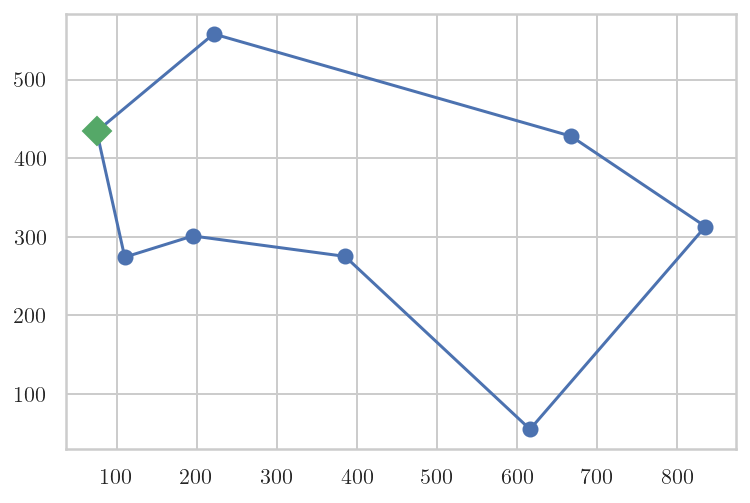

In [13]:
plot_tour(tour)

In [14]:
def all_non_redundant_tours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + list(tour)
            for tour in itertools.permutations(cities - {start})]

def first(collection):
    "Start iterating over collection, and return the first element."
    for x in collection: return x

def exact_non_redundant_TSP(cities):
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(all_non_redundant_tours(cities))

In [15]:
all_non_redundant_tours({1, 2, 3})

[[1, 2, 3], [1, 3, 2]]

In [16]:
%timeit exact_TSP(cities8)

150 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit exact_non_redundant_TSP(cities8)

25 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit exact_non_redundant_TSP(cities10)

1.65 s ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
def greedy_TSP(cities):
    "At each step, visit the nearest neighbor that is still unvisited."
    start = first(cities)
    tour = [start]
    unvisited = cities - {start}
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

In [20]:
def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda x: distance(x, A))

In [21]:
cities = generate_cities(9)

In [22]:
%timeit exact_non_redundant_TSP(cities)

186 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit exact_TSP(cities)

1.42 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit greedy_TSP(cities)

23 µs ± 2.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


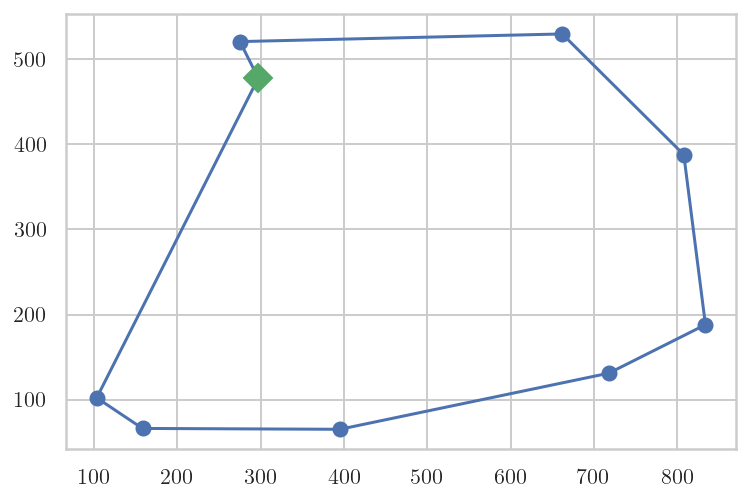

In [25]:
plot_tour(greedy_TSP(cities))

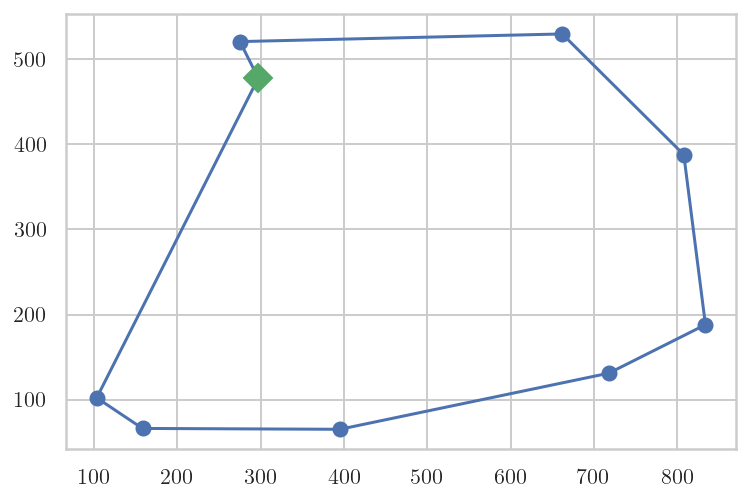

In [26]:
plot_tour(exact_non_redundant_TSP(cities))

In [27]:
total_distance(greedy_TSP(cities))

2025.5115152970852

In [28]:
total_distance(exact_non_redundant_TSP(cities))

2025.5115152970852

# Metaheurísticas inspiradas en la naturaleza

- Hemos visto en clase algunos ejemplos de metaheurísticas inspiradas en la naturaleza.
- Son una opción en la que dedicamos un poco más de esfuerzo computacional para producir mejores soluciones que `greedy_TSP()`.

> Usaremos la biblioteca [DEAP](https://github.com/DEAP/deap) para codificar el abordaje de este problema usando un algoritmo genético.

[<img src='https://raw.githubusercontent.com/DEAP/deap/master/doc/_static/deap_long.png' width='29%' align='center'/>](https://github.com/DEAP/deap)

In [29]:
from deap import algorithms, base, creator, tools

### Elementos para tener en cuenta la resolución de problemas con algoritmos genéticos

* **Representación individual** (binaria, coma-flotante, etc.);
* **evaluación** y **asignación de aptitud**;
* **selección**, que establece un orden parcial de individuos en la población usando su valor de función de aptitud como referencia y determina el grado en que los individuos de la población participarán en la generación de nuevos (descendientes) individuos.
* **variación**, que aplica una gama de operadores inspirados en la evolución, como cruce, mutación, etc., para sintetizar individuos descendientes de la población actual (parental). Se supone que este proceso prepara a los individuos más aptos para que desempeñen un papel más importante en la generación de la descendencia.
* **criterio de parada**, que determina cuándo se debe detener el algoritmo, ya sea porque se alcanzó el óptimo o porque el proceso de optimización no avanza.

### En 'general', un algoritmo evolutivo puede describirse como

```
def evolutionary_algorithm():
    'Pseudocode of an evolutionary algorithm'    
    populations = [] # a list with all the populations
    
    populations[0] =  initialize_population(pop_size)
    t = 0
    
    while not stop_criterion(populations[t]):
        fitnesses = evaluate(populations[t])
        offspring = matting_and_variation(populations[t],
                                          fitnesses)
        populations[t+1] = environmental_selection(           
                                          populations[t],
                                          offspring)
        t = t+1
```

### Preliminares para el experimento.

Realizaremos nuestras pruebas con un problema de 30 ciudades.

In [30]:
num_cities = 30
cities = generate_cities(num_cities)

In [31]:
cities

{(169+484j),
 (173+217j),
 (209+256j),
 (249+101j),
 (255+383j),
 (262+580j),
 (298+492j),
 (31+236j),
 (341+475j),
 (376+248j),
 (415+29j),
 (463+361j),
 (476+181j),
 (50+147j),
 (508+209j),
 (54+401j),
 (607+109j),
 (644+485j),
 (687+404j),
 (727+587j),
 (738+411j),
 (770+133j),
 (78+526j),
 (802+49j),
 (819+132j),
 (83+400j),
 (843+85j),
 (887+561j),
 (90+235j),
 (92+289j)}

`toolbox` almacenó la configuración del algoritmo. Describe los diferentes elementos a tener en cuenta.

In [32]:
toolbox = base.Toolbox()

### Representación y evaluación individual

* Los individuos representan posibles soluciones al problema.
* En el caso de TSP, parece que el recorrido en sí puede ser una representación adecuada.
* Por simplicidad, un individuo puede ser una lista con los índices correspondientes a cada ciudad.
* Esto simplificará los operadores de cruce y mutación.
* Podemos confiar en la función `total_distance()` para la evaluación y establecer la asignación de aptitud para minimizarla.

In [33]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

Definamos ahora que nuestros individuos están compuestos por índices que se refieren a elementos de `ciudades` y, en consecuencia, la población está compuesta por individuos.

In [34]:
toolbox.register("indices", numpy.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

Definir los operadores de cruce y mutación puede ser una tarea desafiante.

Hay varios <a href='http://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)#Crossover_for_Ordered_Chromosomes'> operadores de cruce </a> que se han diseñado para tratar con individuos ordenados como los nuestros.

- Usaremos el crossover `deap.tools.cxOrdered()` de DEAP.
- Para la mutación intercambiaremos elementos de dos puntos del individuo.
- Esto lo realiza `deap.tools.mutShuffleIndexes()`.

In [38]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [ ]:
tour = [6,1,2,4,0,5,3]

La evaluación se puede definir fácilmente a partir de la definición de `total_distance()`.

In [39]:
def create_tour(individual):
    return [list(cities)[e] for e in individual]

In [40]:
def evaluation(individual):
    '''Evaluates an individual by converting it into 
    a list of cities and passing that list to total_distance'''
    return (total_distance(create_tour(individual)),)

In [41]:
toolbox.register("evaluate", evaluation)

Emplearemos la selección de torneos con tamaño 3.

In [42]:
toolbox.register("select", tools.selTournament, tournsize=3)

Ejecutemos el algoritmo con una población de 100 individuos y 400 generaciones.

In [43]:
pop = toolbox.population(n=100)

In [44]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False)

CPU times: user 5.54 s, sys: 64.7 ms, total: 5.6 s
Wall time: 5.79 s


### Ahora podemos revisar los resultados

El mejor individuo de la última población:

In [45]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  4196.879669018253


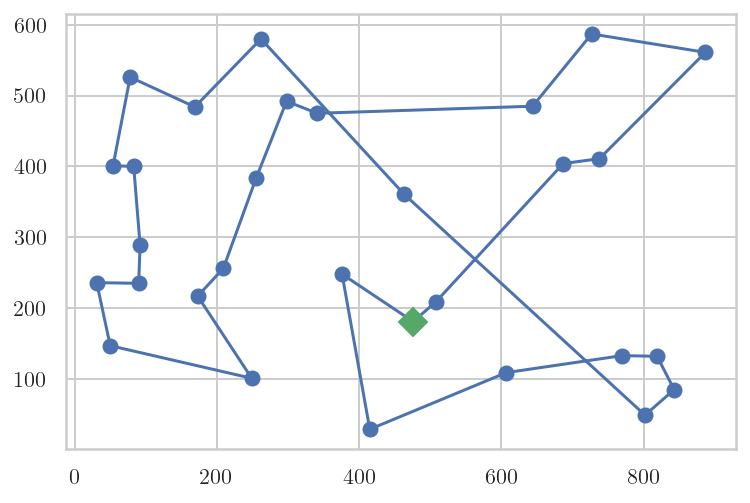

In [46]:
plot_tour(create_tour(best_individual))

Es interesante evaluar cómo cambió la aptitud de la población a medida que tuvo lugar el proceso de evolución.

Podemos preparar una instancia `deap.tools.Statistics` para especificar qué datos recopilar.

In [47]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', numpy.mean)
fit_stats.register('min', numpy.min)

Ya estamos listos, pero volvamos a ejecutar el algoritmo genético configurado para recopilar las estadísticas que queremos recopilar:

In [48]:
result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.5, mutpb=0.2,
                                  ngen=400, verbose=False,
                                  stats=fit_stats)

### Dibujar la aptitud media y mínima a medida que tuvo lugar la evolución.

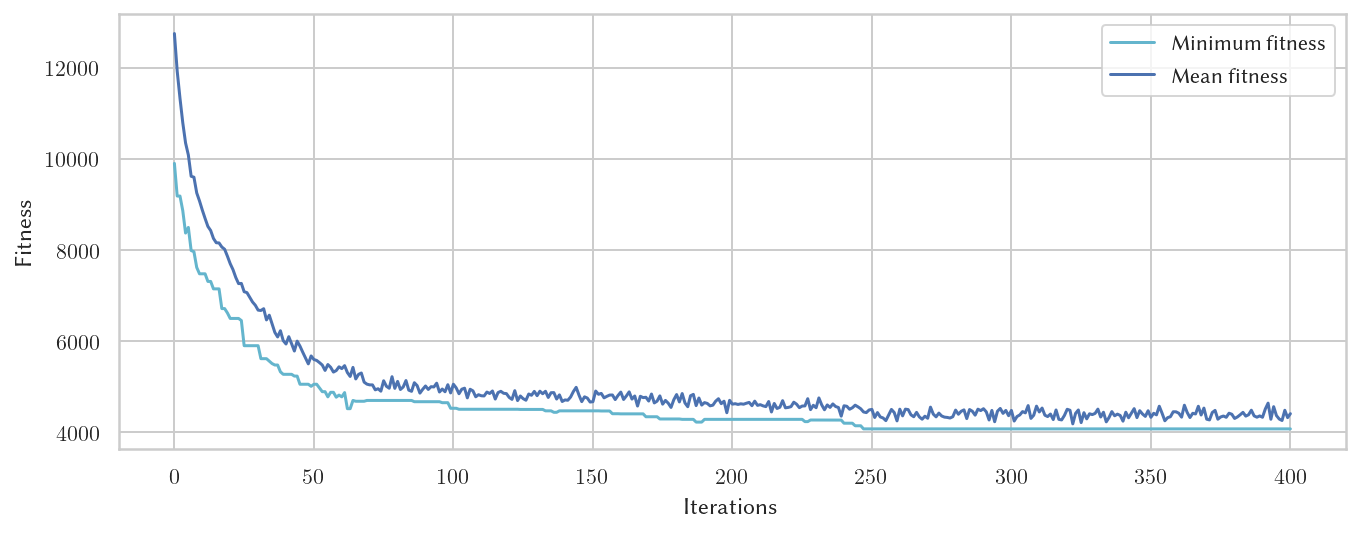

In [49]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

### ¿Cómo ha evolucionado la población?

Ok, pero ¿cómo evolucionó la población? Como las soluciones de TSP son fáciles de visualizar, podemos trazar los individuos de cada población en la que progresó la evolución. Necesitamos una nueva instancia de "Estadísticas" preparada para eso.

In [50]:
pop_stats = tools.Statistics(key=numpy.copy)
pop_stats.register('pop', numpy.copy) # -- copies the populations themselves
pop_stats.register('fitness', # -- computes and stores the fitnesses
                   lambda x : [evaluation(a) for a in x]) 

*Nota*: Soy consciente de que esto podría hacerse de una manera más eficiente.

In [51]:
result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.5, mutpb=0.2,
                                  ngen=400, verbose=False,
                                  stats=pop_stats)

### Representación de los individuos y su estado físico (codificados por colores)

In [52]:
def plot_population(record, min_fitness, max_fitness):
    '''
    Plots all individuals in a population. 
    Darker individuals have a better fitness.
    '''
    pop = record['pop']
    fits = record['fitness']
    index = sorted(range(len(fits)), key=lambda k: fits[k])

    norm=colors.Normalize(vmin=min_fitness,
                          vmax=max_fitness)
    sm = cmx.ScalarMappable(norm=norm, 
                            cmap=plt.get_cmap('PuBu'))
    
    for i in range(len(index)):
        color = sm.to_rgba(max_fitness - fits[index[i]][0])
        plot_tour(create_tour(pop[index[i]]), alpha=0.5, color=color)

In [53]:
min_fitness = numpy.min(log.select('fitness'))
max_fitness = numpy.max(log.select('fitness'))

Ahora podemos dibujar la población a medida que avanzaba el proceso evolutivo. Los colores azules más oscuros implican un mejor estado físico.

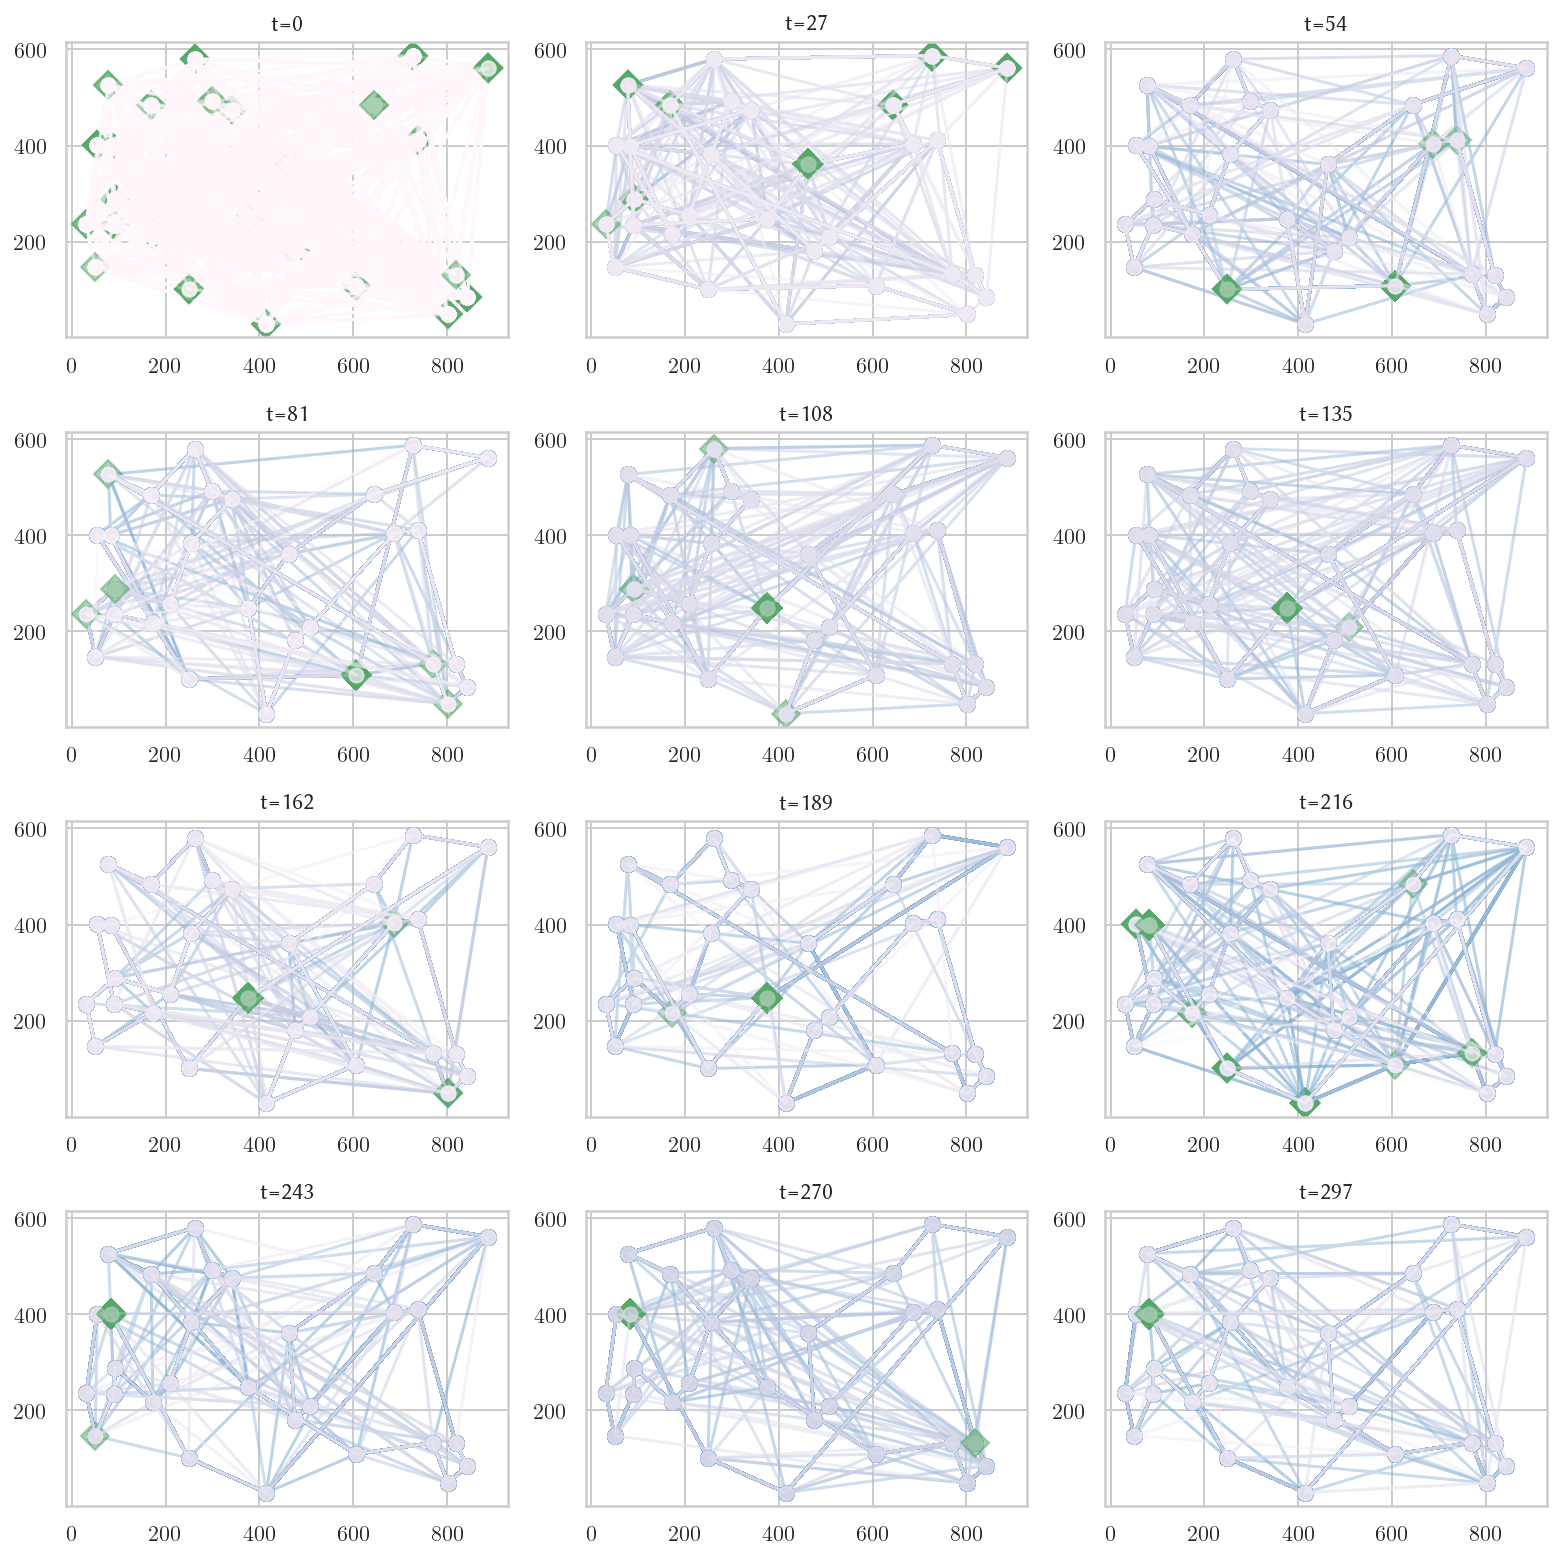

In [54]:
plt.figure(figsize=(11,11))
for i in range(0, 12):
    plt.subplot(4,3,i+1)
    it = int(math.ceil((len(log)-1.)/15))
    plt.title('t=' + str(it*i))
    plot_population(log[it*i], min_fitness, max_fitness)
plt.tight_layout()

La población del experimento anterior se puede apreciar mejor en forma animada.

In [55]:
from matplotlib import animation
from IPython.display import HTML

In [56]:
def update_plot_tour(plot, points, alpha=1, color='blue'):
    'A function for updating a plot with an individual'
    X, Y = XY(list(points) + [points[0]])
    plot.set_data(X, Y)
    plot.set_color(color)
    return plot

In [57]:
def init():
    'Initialization of all plots to empty data'
    for p in list(tour_plots):
        p.set_data([], [])
    return tour_plots

In [58]:
def animate(i):
    'Updates all plots to match frame _i_ of the animation' 
    pop = log[i]['pop']
    fits = log[i]['fitness']
    index = sorted(range(len(fits)), key=lambda k: fits[k])

    norm=colors.Normalize(vmin=min_fitness,
                          vmax=max_fitness)
    sm = cmx.ScalarMappable(norm=norm, 
                            cmap=plt.get_cmap('PuBu'))
    for j in range(len(tour_plots)):
        color = sm.to_rgba(max_fitness - fits[index[j]][0])
        update_plot_tour(tour_plots[j], 
                         create_tour(pop[index[j]]), 
                         alpha=0.5, color=color)
    return tour_plots

El siguiente paso tarda algún tiempo en ejecutarse. Utilice los controles de video para ver la evolución en forma animada.

In [59]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 900), ylim=(0, 600))
tour_plots = [ax.plot([], [], 'bo-', alpha=0.1) for i in range(len(log[0]['pop']))]
tour_plots = [p[0] for p in tour_plots]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=60, blit=True)
plt.close()

In [60]:
HTML(anim.to_html5_video())

### Comparación con `greedy_TSP()`

In [61]:
%timeit total_distance(greedy_TSP(cities))

177 µs ± 7.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
print('greedy_TSP() distance: ', total_distance(greedy_TSP(cities)))
print('Genetic algorithm best distance: ', evaluation(best_individual)[0])

greedy_TSP() distance:  4373.545482145501
Genetic algorithm best distance:  4196.879669018253


In [ ]:
# To install run: pip install version_information
%load_ext version_information
%version_information scipy, numpy, matplotlib, seaborn, deap

In [ ]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))